# 2. Demo on J-LORAKS + Joint VS-Net  versus ZPAD + Joint VS-Net

In [1]:
import scipy.io as io
import numpy as np
import torch
from JVS_net_v2 import *
device = 'cuda:0' # Device number for GPU

In [2]:
h1 = io.loadmat('JLORAKS.mat')
h2 = io.loadmat('ZPAD.mat')
print(h2.keys())

dict_keys(['mask_10', 'ZP_6', 'mask_4', 'Xk_8', 'ZP_10', '__globals__', 'ZP_8', '__version__', 'Xk_6', 'Xk_10', 'mask_6', '__header__', 'Xk_4', 'true', 'mask_8', 'ZP_4', 'Sens'])


**Description of the dataset(h2) **
- ZP_4 (6,8,10) : ZPAD result of R = 4 (6,8,10) 
- Xk_4 (6,8,10) : acquired k-space of R = 4 (6,8,10)
- mask_4 (6,8,10) : acquired k-space mask of R=4 (6,8,10)
- Sens : Sensitivity maps
- true : fully sampled result (image domain)

**Loading the trained network architecture (note that the two network architecture is identical) **

In [3]:
net1 = network(alfa=None, beta=0.5, cascades = 8)
net1 = net1.to(device)
net1.load_state_dict(torch.load('Weights_LORAKS')) #JLORAKS + JVSnet

net2 = network(alfa=None, beta=0.5, cascades = 8)
net2 = net2.to(device)
net2.load_state_dict(torch.load('Weights_ZPAD')) # ZPAD + JVSnet

## 1-1 Result of R=8

In [4]:
im0, Zim0, true, Sens, X_k, mask = torch.from_numpy(h1['JL_8']), torch.from_numpy(h2['ZP_8']),\
h1['true'],torch.from_numpy(h1['Sens']),\
torch.from_numpy(h1['Xk_8']),torch.from_numpy(h1['mask_8'])

JL_im = h1['JL_8'] # JLORAKS output
ZP_im = h2['ZP_8']

_im0, _zim0, _Sens, _X_k, _mask = im0.unsqueeze(0).to(device), Zim0.unsqueeze(0).to(device),\
Sens.unsqueeze(0).to(device),\
X_k.unsqueeze(0).to(device), mask.unsqueeze(0).to(device)

with torch.no_grad():
    out1 = net1(_im0,_X_k,_mask,_Sens)
    out1 = out1.detach().cpu().numpy()
    out2 = net2(_zim0,_X_k,_mask,_Sens)
    out2 = out2.detach().cpu().numpy()
    
JL_im = np.squeeze(JL_im[...,0] + 1j * true[...,1])
JL_im = np.transpose(JL_im,(1,2,0))
JL_im = JL_im.reshape((300,192,4,2)) # change to xRes,yRes,TD,TE order    

ZP_im = np.squeeze(ZP_im[...,0] + 1j * true[...,1])
ZP_im = np.transpose(ZP_im,(1,2,0))
ZP_im = ZP_im.reshape((300,192,4,2)) # change to xRes,yRes,TD,TE order    

out1 = np.squeeze(out1[...,0] + 1j * out1[...,1])
out1 = np.transpose(out1,(1,2,0))
out1 = out1.reshape((300,192,4,2)) # change to xRes,yRes,TD,TE order

out2 = np.squeeze(out2[...,0] + 1j * out2[...,1])
out2 = np.transpose(out2,(1,2,0))
out2 = out2.reshape((300,192,4,2)) # change to xRes,yRes,TD,TE order

true = np.squeeze(true[...,0] + 1j * true[...,1])
true = np.transpose(true,(1,2,0))
true = true.reshape((300,192,4,2)) # change to xRes,yRes,TD,TE order


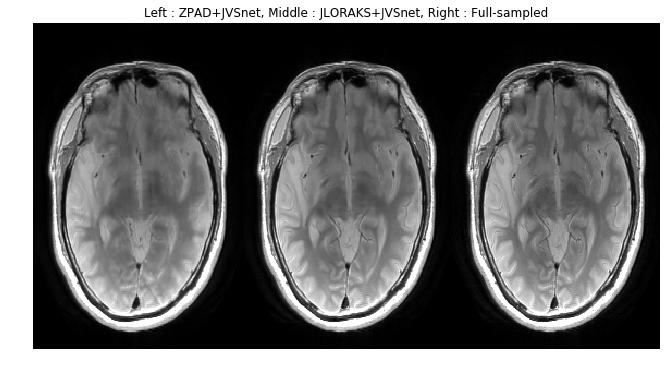

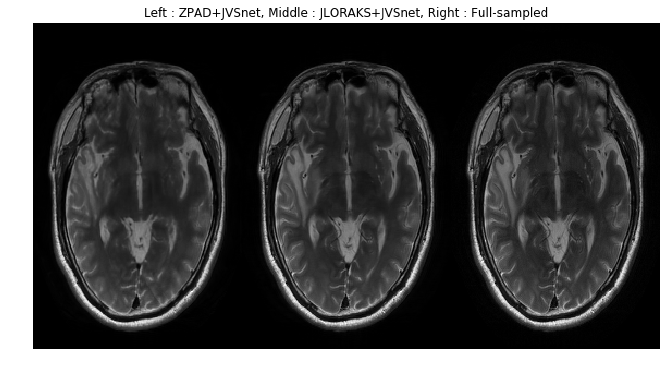

In [5]:
cat_im1 = np.concatenate((out2[:,:,0,0],out1[:,:,0,0],true[:,:,0,0]),axis=1) # 1st TD, 1st TE result
cat_im2 = np.concatenate((out2[:,:,2,0],out1[:,:,2,0],true[:,:,2,0]),axis=1) # 3rd TD, 1st TE result

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.imshow(np.abs(cat_im1),cmap='gray',vmax=1.2)
plt.axis('off')
plt.title('Left : ZPAD+JVSnet, Middle : JLORAKS+JVSnet, Right : Full-sampled')

plt.figure(figsize=(14,6))
plt.imshow(np.abs(cat_im2),cmap='gray',vmax=1.2)
plt.axis('off')
plt.title('Left : ZPAD+JVSnet, Middle : JLORAKS+JVSnet, Right : Full-sampled')


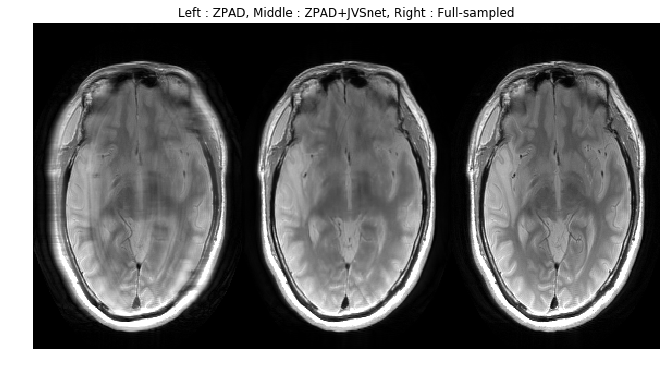

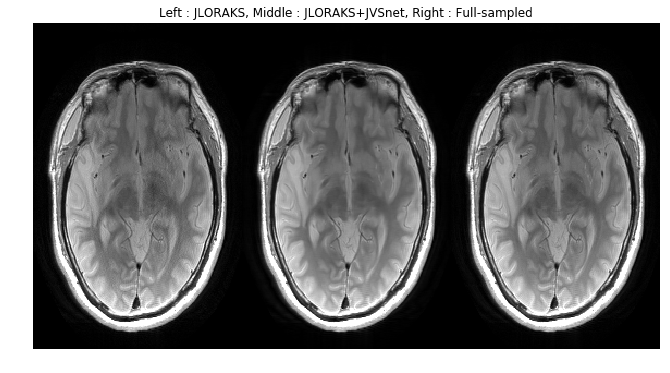

In [6]:
cat_im1 = np.concatenate((ZP_im[:,:,0,0],out2[:,:,0,0],true[:,:,0,0]),axis=1) 
cat_im2 = np.concatenate((JL_im[:,:,0,0],out1[:,:,0,0],true[:,:,0,0]),axis=1) 

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.imshow(np.abs(cat_im1),cmap='gray',vmax=1.2)
plt.axis('off')
plt.title('Left : ZPAD, Middle : ZPAD+JVSnet, Right : Full-sampled')

plt.figure(figsize=(14,6))
plt.imshow(np.abs(cat_im2),cmap='gray',vmax=1.2)
plt.axis('off')
plt.title('Left : JLORAKS, Middle : JLORAKS+JVSnet, Right : Full-sampled')

